# Notebook to plot SED results from CIGALE in a cool fashion for your slides

The whole idea to create these kind of plots was inspired in a presentation of Fédéric Galliano. Check out his slides!

https://irfu.cea.fr/Pisp/frederic.galliano/Talks/astrodat2019_Galliano.pdf

https://irfu.cea.fr/Pisp/frederic.galliano/Talks/seminarLAM2019_Galliano.pdf

In [2]:
'''
Jorge Andrés Villa-Vélez
Laboratoire d'Astrophysique de Marseille (LAM)
jorgevilla.91@gmail.com / jorge.villa@lam.fr 

'''

# Regular packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table, Column
import scipy.integrate as integrate
import os
from matplotlib.legend_handler import HandlerPathCollection
from matplotlib.ticker import (FormatStrFormatter, MultipleLocator, AutoMinorLocator)
from sklearn.linear_model import LinearRegression
import pandas as pd

%matplotlib inline

# SED example

In [3]:
def transpose_table(tab_before, id_col_name='ID'):
    '''Returns a copy of tab_before (an astropy.Table) with rows and columns interchanged
        id_col_name: name for optional ID column corresponding to
        the column names of tab_before'''
    # contents of the first column of the old table provide column names for the new table
    # TBD: check for duplicates in new_colnames & resolve
    new_colnames=tuple(tab_before[tab_before.colnames[0]])
    # remaining columns of old table are row IDs for new table 
    new_rownames=tab_before.colnames[1:]
    # make a new, empty table
    tab_after=Table(names=new_colnames)
    # add the columns of the old table as rows of the new table
    for r in new_rownames:
        tab_after.add_row(tab_before[r])
    if id_col_name != '':
        # add the column headers of the old table as the id column of new table
        tab_after.add_column(Column(new_rownames, name=id_col_name),index=0)
    return(tab_after)

In [4]:
# # Values taken from https://arxiv.org/pdf/1807.06209.pdf
# H0 = 2.184e-21 # km s^−1 m^−1 (67.4 km s^−1 Mpc^−1)
# c  = 2.99792e5 # km s^−1
# Om = 0.315
# Ol = 1.0 - Om

# Updated values to be consistent with CIGALE
H0 = 2.282e-21 # km s^−1 m^−1 (67.4 km s^−1 Mpc^−1)
c  = 2.99792e5 # km s^−1
Om = 0.273
Ol = 1.0 - Om

# Line-emission luminosity
def luminosity_to_flux(luminosity, z ,Om, Ol, c, H0):
    
    flux = []
    for i in range(len(luminosity)):
        
        d = (c/H0)*(1.0 + z[i])
    
        integral = integrate.quad(lambda x: ((1.0 + x)**2*(1.0 + Om*x) - Ol*x*(2.0 + x))**(-1.0/2.0), 0.0, z[i])
    
        F =  ( luminosity[i] / ( 4.0*np.pi*( d*integral[0] )**2 ) )
        flux.append(F)
    
    return(np.array(flux)) # Flux in W m^-2

# Data

This is an example of a galaxy I fitted for my thesis work based on a FMOS-COSMOS sample

In [5]:
path = '/Users/lam/Desktop/SED_Plot_thesis/Data/'

sed = Table.read(path+'FMOS_J100009.0+024011_best_model.fits', format = 'fits')
obs = Table.read(path+'observations.txt', format = 'ascii')
res = Table.read(path+'results.txt', format = 'ascii')

original = Table.read(path+'observations.txt', format = 'ascii')

In [6]:
obs = obs[obs['id'] == 'FMOS_J100009.0+024011']
res = res[res['id'] == 'FMOS_J100009.0+024011']

In [7]:
# Filter need to be changed according to what one has used in the SED fitting
# Names are compatible to what's inside CIGALE

Filters = ['galex.NUV', 'cfht.megacam.u',\
           'subaru.suprime.B', 'subaru.suprime.V', \
           'subaru.suprime.r', 'subaru.suprime.i',\
           'subaru.suprime.z', 'subaru.hsc.y',\
           'UKIRT_WFCJ', 'cfht.wircam.H',\
           'WFCAM_K', 'IRAC1', \
           'IRAC2','IRAC3',\
           'IRAC4','spitzer.mips.24',\
           'herschel.pacs.100',\
           'herschel.pacs.160',\
           'herschel.spire.PSW',\
           'herschel.spire.PMW',\
           'herschel.spire.PLW']

In [8]:
Obs      = []
Obs_err  = []

for i in range(len(Filters)):
    observations     = obs[Filters[i]]
    observations_err = obs[Filters[i]+'_err']
    
    a = observations[0]
    b = observations_err[0]*3 # The 3 comes from CIGALE
    Obs.append(a)
    Obs_err.append(b)
    
Models = []

for j in range(len(Filters)):
    
    models_cigale = res['best.'+Filters[j]] 
    Models.append(models_cigale[0])

In [9]:
# I obtained this from CIGALE using another code when I plot the filters

filters_wavelength = [2.29924500e-01, 3.82657613e-01, 4.44802344e-01, 5.47022023e-01,
                      6.27552396e-01, 7.67126647e-01, 9.02821612e-01, 9.78660196e-01,
                      1.25358020e+00, 1.62868125e+00, 2.23330676e+00, 3.55669064e+00,
                      4.50196520e+00, 5.74500412e+00, 7.91821223e+00, 2.35934768e+01,
                      1.00651332e+02, 1.60976321e+02, 2.48540339e+02, 3.48159591e+02,
                      5.00794940e+02]

filters_wavelength = np.multiply(filters_wavelength, 1e-3)

# SED components

In [13]:
stellar_unattenuated = sed['stellar.old'] + sed['stellar.young']
stellar_attenuated   = sed['stellar.young']+sed['attenuation.stellar.young']+sed['nebular.absorption_young']+sed['stellar.old']+sed['attenuation.stellar.old']+sed['nebular.absorption_old']
unattenuated_luminosity = np.array(stellar_unattenuated*sed['wavelength'])
attenuated_luminosity = np.array(stellar_attenuated*sed['wavelength'])

nebular_emission   = sed['nebular.lines_young'] + sed['nebular.lines_old'] + sed['nebular.continuum_young'] + sed['nebular.continuum_old'] + sed['attenuation.nebular.lines_young'] + sed['attenuation.nebular.lines_old'] + sed['attenuation.nebular.continuum_young'] + sed['attenuation.nebular.continuum_old']
nebular_luminosity = np.array(nebular_emission*sed['wavelength'])

dust_emission = sed['dust.Umin_Umin'] + sed['dust.Umin_Umax']
dust_luminosity = np.array(dust_emission*sed['wavelength'])

z_object = original['redshift'][0]
z = np.repeat(z_object, len(attenuated_luminosity))

In [14]:
stellar_unattenuated_luminosity = luminosity_to_flux(luminosity = unattenuated_luminosity,
                                                     z = z, Om = Om, Ol = Ol, c = c, H0 = H0)
stellar_attenuated_luminosity   = luminosity_to_flux(luminosity = attenuated_luminosity,
                                                     z = z, Om = Om, Ol = Ol, c = c, H0 = H0)
nebular_emission_luminosity     = luminosity_to_flux(luminosity = nebular_luminosity,
                                                     z = z, Om = Om, Ol = Ol, c = c, H0 = H0)
dust_emission_luminosity        = luminosity_to_flux(luminosity = dust_luminosity,
                                                     z = z, Om = Om, Ol = Ol, c = c, H0 = H0)

# SED plots

In [15]:
# Activate the dark mode for the plots

plt.style.use('dark_background')

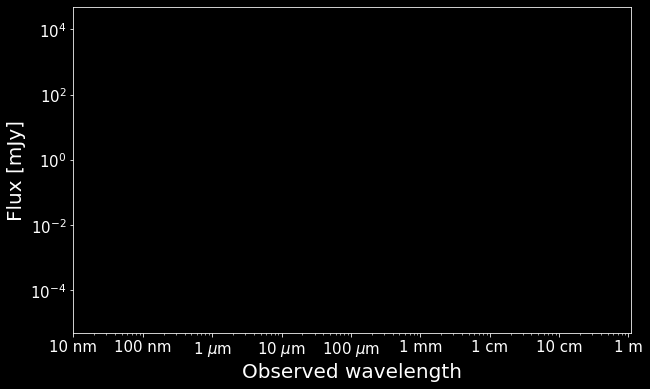

In [16]:
scale = 1e29*sed['wavelength']*1e-12/c # 1e29 to obtain mJy; lambda*1e-12/c to obtain W m^-2 Hz-1

plt.figure(figsize=(10,6))

plt.ylim(5e-6, 5e4)
plt.xlim(0.01, 1.1e6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed wavelength', fontsize = 20)
plt.ylabel('Flux [mJy]', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', direction = 'out', labelsize = 15)
plt.tick_params(axis = 'both', which = 'minor', direction = 'out', labelsize = 15)
labels = ['10 nm', '100 nm', '1 $\mu$m', '10 $\mu$m', '100 $\mu$m',
          '1 mm', '1 cm', '10 cm', '1 m']
x      = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
plt.xticks(x, labels)
# plt.savefig('/Users/lam/Desktop/0.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# plt.legend(frameon = False, prop = {'size': 12}, markerscale = 1.5 , loc = 'best')

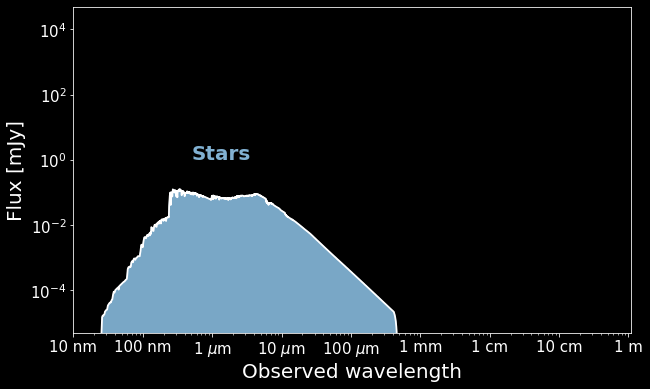

In [17]:
plt.figure(figsize=(10,6))

plt.plot(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, lw = 1.8, c = 'white')
plt.fill_between(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, color = '#81b1d2', alpha = 0.95)
plt.text(5e-1, 1e0, 'Stars', fontsize = 20, color = '#81b1d2', weight = 'bold')

plt.ylim(5e-6, 5e4)
plt.xlim(0.01, 1.1e6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed wavelength', fontsize = 20)
plt.ylabel('Flux [mJy]', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', direction = 'out', labelsize = 15)
plt.tick_params(axis = 'both', which = 'minor', direction = 'out', labelsize = 15)
labels = ['10 nm', '100 nm', '1 $\mu$m', '10 $\mu$m', '100 $\mu$m',
          '1 mm', '1 cm', '10 cm', '1 m']
x      = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
plt.xticks(x, labels)
# plt.savefig('/Users/lam/Desktop/1.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# plt.legend(frameon = False, prop = {'size': 12}, markerscale = 1.5 , loc = 'best')

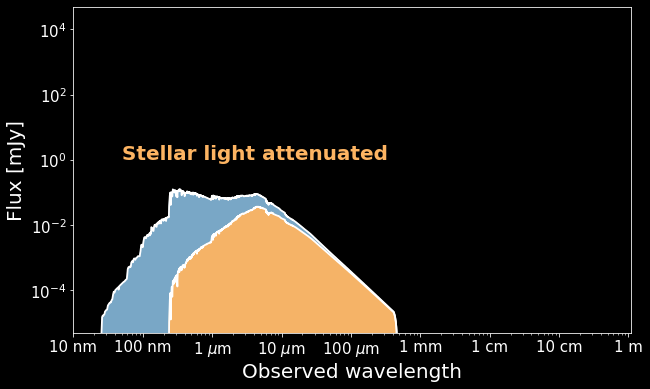

In [18]:
plt.figure(figsize=(10,6))

plt.plot(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, lw = 1.8, c = 'white')
plt.plot(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, lw = 1.8, c = 'white')

plt.fill_between(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, color = '#81b1d2', alpha = 0.95)
plt.fill_between(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, color = '#fdb462', alpha = 0.95)
plt.text(0.5e-1, 1e0, 'Stellar light attenuated', fontsize = 20, color = '#fdb462', weight = 'bold')

plt.ylim(5e-6, 5e4)
plt.xlim(0.01, 1.1e6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed wavelength', fontsize = 20)
plt.ylabel('Flux [mJy]', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', direction = 'out', labelsize = 15)
plt.tick_params(axis = 'both', which = 'minor', direction = 'out', labelsize = 15)
labels = ['10 nm', '100 nm', '1 $\mu$m', '10 $\mu$m', '100 $\mu$m',
          '1 mm', '1 cm', '10 cm', '1 m']
x      = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
plt.xticks(x, labels)
# plt.savefig('/Users/lam/Desktop/2.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# plt.legend(frameon = False, prop = {'size': 12}, markerscale = 1.5 , loc = 'best')

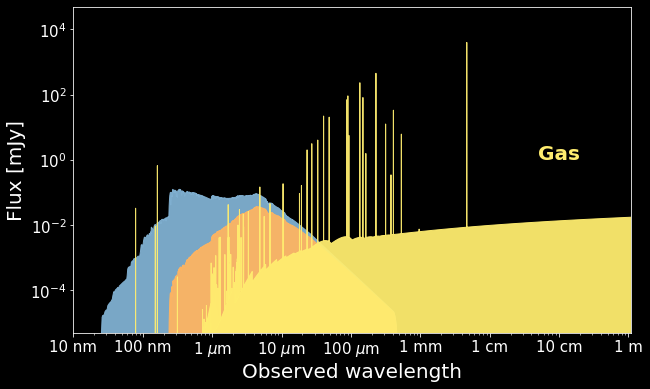

In [19]:
plt.figure(figsize=(10,6))

# plt.plot(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, lw = 1.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, lw = 1.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*nebular_emission_luminosity, lw = 0.8, c = 'white')

plt.fill_between(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, color = '#81b1d2', alpha = 0.95)
plt.fill_between(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, color = '#fdb462', alpha = 0.95)
plt.fill_between(sed['wavelength']/1e3, scale*nebular_emission_luminosity, color = '#ffed6f', alpha = 0.95)
plt.text(5e4, 1e0, 'Gas', fontsize = 20, color = '#ffed6f', weight = 'bold')

plt.ylim(5e-6, 5e4)
plt.xlim(0.01, 1.1e6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed wavelength', fontsize = 20)
plt.ylabel('Flux [mJy]', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', direction = 'out', labelsize = 15)
plt.tick_params(axis = 'both', which = 'minor', direction = 'out', labelsize = 15)
labels = ['10 nm', '100 nm', '1 $\mu$m', '10 $\mu$m', '100 $\mu$m',
          '1 mm', '1 cm', '10 cm', '1 m']
x      = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
plt.xticks(x, labels)
# plt.savefig('/Users/lam/Desktop/3.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# plt.legend(frameon = False, prop = {'size': 12}, markerscale = 1.5 , loc = 'best')

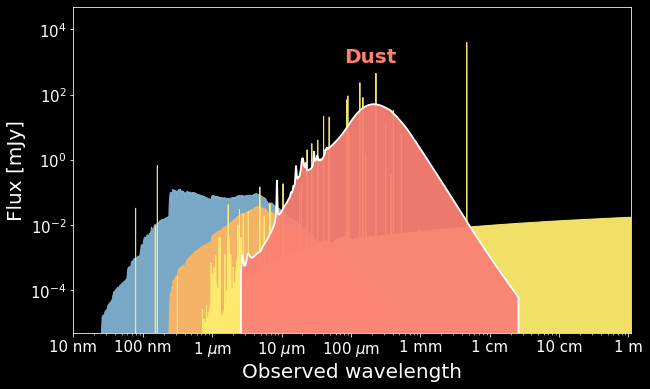

In [20]:
plt.figure(figsize=(10,6))

# plt.plot(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, lw = 1.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, lw = 1.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*nebular_emission_luminosity, lw = 0.8, c = 'white')
plt.plot(sed['wavelength']/1e3, scale*dust_emission_luminosity, lw = 1.8, c = 'white')

plt.fill_between(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, color = '#81b1d2', alpha = 0.95)
plt.fill_between(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, color = '#fdb462', alpha = 0.95)
plt.fill_between(sed['wavelength']/1e3, scale*nebular_emission_luminosity, color = '#ffed6f', alpha = 0.95)
plt.fill_between(sed['wavelength']/1e3, scale*dust_emission_luminosity, color = '#fa8174', alpha = 0.95)
plt.text(8e1, 1e3, 'Dust', fontsize = 20, color = '#fa8174', weight = 'bold')

plt.ylim(5e-6, 5e4)
plt.xlim(0.01, 1.1e6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed wavelength', fontsize = 20)
plt.ylabel('Flux [mJy]', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', direction = 'out', labelsize = 15)
plt.tick_params(axis = 'both', which = 'minor', direction = 'out', labelsize = 15)
labels = ['10 nm', '100 nm', '1 $\mu$m', '10 $\mu$m', '100 $\mu$m',
          '1 mm', '1 cm', '10 cm', '1 m']
x      = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
plt.xticks(x, labels)
# plt.savefig('/Users/lam/Desktop/4.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# plt.legend(frameon = False, prop = {'size': 12}, markerscale = 1.5 , loc = 'best')

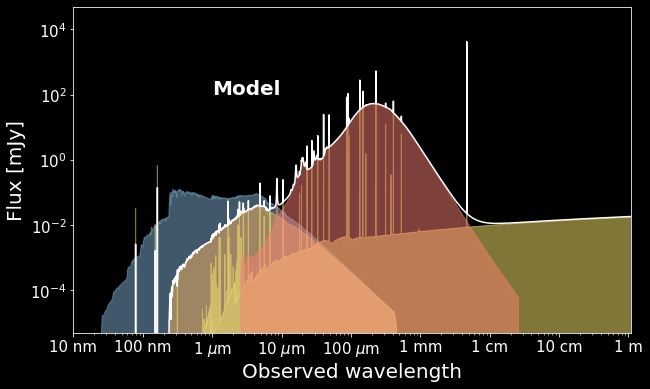

In [21]:
plt.figure(figsize=(10,6))

# plt.plot(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, lw = 1.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, lw = 1.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*nebular_emission_luminosity, lw = 0.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*dust_emission_luminosity, lw = 1.8, c = 'white')

plt.fill_between(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, color = '#81b1d2', alpha = 0.5)
plt.fill_between(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, color = '#fdb462', alpha = 0.5)
plt.fill_between(sed['wavelength']/1e3, scale*nebular_emission_luminosity, color = '#ffed6f', alpha = 0.5)
plt.fill_between(sed['wavelength']/1e3, scale*dust_emission_luminosity, color = '#fa8174', alpha = 0.5)
plt.plot(sed['wavelength']/1e3, sed['Fnu'], lw = 1.5, c = 'white')


plt.text(1e0, 1e2, 'Model', fontsize = 20, color = 'white', weight = 'bold')


plt.ylim(5e-6, 5e4)
plt.xlim(0.01, 1.1e6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed wavelength', fontsize = 20)
plt.ylabel('Flux [mJy]', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', direction = 'out', labelsize = 15)
plt.tick_params(axis = 'both', which = 'minor', direction = 'out', labelsize = 15)
labels = ['10 nm', '100 nm', '1 $\mu$m', '10 $\mu$m', '100 $\mu$m',
          '1 mm', '1 cm', '10 cm', '1 m']
x      = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
plt.xticks(x, labels)
# plt.savefig('/Users/lam/Desktop/5.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# plt.legend(frameon = False, prop = {'size': 12}, markerscale = 1.5 , loc = 'best')

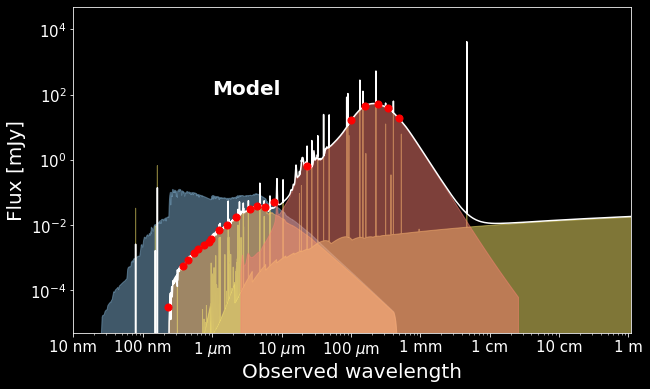

In [23]:
plt.figure(figsize=(10,6))

# plt.plot(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, lw = 1.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, lw = 1.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*nebular_emission_luminosity, lw = 0.8, c = 'white')
# plt.plot(sed['wavelength']/1e3, scale*dust_emission_luminosity, lw = 1.8, c = 'white')

plt.fill_between(sed['wavelength']/1e3, scale*stellar_unattenuated_luminosity, color = '#81b1d2', alpha = 0.5)
plt.fill_between(sed['wavelength']/1e3, scale*stellar_attenuated_luminosity, color = '#fdb462', alpha = 0.5)
plt.fill_between(sed['wavelength']/1e3, scale*nebular_emission_luminosity, color = '#ffed6f', alpha = 0.5)
plt.fill_between(sed['wavelength']/1e3, scale*dust_emission_luminosity, color = '#fa8174', alpha = 0.5)
plt.plot(sed['wavelength']/1e3, sed['Fnu'], lw = 1.5, c = 'white')
# plt.errorbar(filters_wavelength*1e3, Obs, yerr = Obs_err,  c = 'dimgray', ls='', lw = 1.5, marker='s',\
#              markerfacecolor='None',\
#              markersize=10, markeredgecolor='dimgray', capsize=0., label='Observed fluxes')
plt.scatter(filters_wavelength*1e3, Models, c = 'red', zorder=6, s = 50)

# plt.text(1e0, 1e2, 'Fluxes', fontsize = 20, color = 'r', weight = 'bold')
plt.text(1e0, 1e2, 'Model', fontsize = 20, color = 'white', weight = 'bold')



plt.ylim(5e-6, 5e4)
plt.xlim(0.01, 1.1e6)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Observed wavelength', fontsize = 20)
plt.ylabel('Flux [mJy]', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', direction = 'out', labelsize = 15)
plt.tick_params(axis = 'both', which = 'minor', direction = 'out', labelsize = 15)
labels = ['10 nm', '100 nm', '1 $\mu$m', '10 $\mu$m', '100 $\mu$m',
          '1 mm', '1 cm', '10 cm', '1 m']
x      = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
plt.xticks(x, labels)
# plt.savefig('/Users/lam/Desktop/7.png', dpi = 300, bbox_inches = 'tight')
plt.show()

# plt.legend(frameon = False, prop = {'size': 12}, markerscale = 1.5 , loc = 'best')